In [ ]:
#Programmer: Peyman Kor, University of Stavanger- April, 2019
#email:p.kor@stud.uis.no
#This code has been written to find the connectivities amoung the 5 wells, in 5-spot pattern using Fast Marching Method.

In [3]:
# You need the following packages and it must be installed. 
!pip install pandas
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scikit-fmm

In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skfmm

In [3]:
# Check your working directory!
os.getcwd()

'C:\\Users\\Peyman\\OneDrive - Universitetet i Stavanger\\ML-5spot-INJ-SGS\\Rcode'

In [4]:
# Change your working directory to the address you have the your PERMX.inc file, the eclipse file for permeability I am using
# in the code. But, you could use any permeability data you have.
newpath='C:\\Users\\Peyman\\OneDrive - Universitetet i Stavanger\\Github\\FMM'
os.chdir(newpath)
os.getcwd()

'C:\\Users\\Peyman\\OneDrive - Universitetet i Stavanger\\Github\\FMM'

In [5]:
# The permeability data in this case is the 100-100 grid wich is 10000 permeability data.
data=pd.read_csv('PERMX.inc')
data.tail(10)

,PERMX
9991,499.781366102794
9992,542.028224961591
9993,548.113352917543
9994,604.106992919776
9995,567.628979879705
9996,514.281842241502
9997,523.677599589808
9998,527.913816354599
9999,532.287443184933
10000,/


In [6]:
# The following codes removes the last datapoint from the permeability data, (/) and as well reshape the permeability
#100 X 100 grid structire.
#Then, the np.log10 calculates the log 10 of the permeability data.
Perm=data.values
Perm=np.delete(Perm,10000)
Perm=np.asarray(Perm, dtype=np.float)
Perm=np.reshape(Perm,(100,100))
Perm_log=np.log10(Perm)
Perm_log

array([[2.55300951, 2.53015089, 2.52734804, ..., 2.73926735, 2.72247458,
        2.70523381],
       [2.54823637, 2.54206419, 2.52234793, ..., 2.71114182, 2.7127564 ,
        2.71895218],
       [2.57236528, 2.55557775, 2.53474116, ..., 2.7286253 , 2.69862199,
        2.68514228],
       ...,
       [2.65147281, 2.66511345, 2.69156742, ..., 2.75686622, 2.7327044 ,
        2.67002821],
       [2.66384649, 2.69479918, 2.68995976, ..., 2.70901895, 2.71902299,
        2.69527149],
       [2.64959836, 2.67512751, 2.68403292, ..., 2.719064  , 2.72256303,
        2.72614622]])

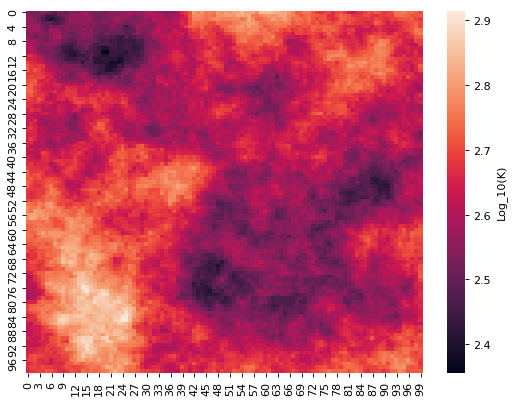

In [7]:
#We plot the permeability data to show the distribution of permeability data.
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
a=np.amin(Perm_log)
b=np.amax(Perm_log)
ax = sns.heatmap(Perm_log,vmin=a,vmax=b,cbar_kws={'label': 'Log_10(K)'})

In [8]:
#Now, in the fast marching method, you need the square root of the transmisibility. We use the same value for porosity, 
#viscosity and compressibility, but they could take any different value. The conversion, converts the permeability in md 
#square m to have consistent dimension.
por=0.2
miu=10**-3
c_t= 3.48*10**(-10)
conversion=9.87*10**-16
speed=(Perm*conversion/por/miu/c_t)**0.5

In [10]:
#overview of the speed data, F in equation presented in the powerpoint.
speed

array([[2.25091301, 2.19244851, 2.1853851 , ..., 2.78925122, 2.73584346,
        2.68207466],
       [2.23857754, 2.22272662, 2.17284086, ..., 2.70037991, 2.70540416,
        2.72477124],
       [2.30163577, 2.25757836, 2.20406571, ..., 2.75528549, 2.66173583,
        2.62074699],
       ...,
       [2.52110167, 2.5610065 , 2.64020511, ..., 2.84634189, 2.76825541,
        2.57553859],
       [2.55727365, 2.65004683, 2.63532292, ..., 2.6937881 , 2.72499338,
        2.65148822],
       [2.51566691, 2.59070349, 2.61740191, ..., 2.72512203, 2.73612208,
        2.74743273]])

In [11]:
# the following table shows the location of 4 injection wells in the grid. We assume that the production well is located
# in the grid 49,49.
loc_well = pd.DataFrame(np.array([[13,82,23,55,44,95,1,82]]),
                   columns=['X1', 'X2', 'X3','X4','Y1','Y2','Y3','Y4'])
loc_well

,X1,X2,X3,X4,Y1,Y2,Y3,Y4
0,13,82,23,55,44,95,1,82


In [18]:
# The input is the matrix to save the results of connectivities between wells.
input = pd.DataFrame(np.array([(np.arange(1,18))]),
                   columns=['ConI1I2', 'ConI1I3', 'ConI1I4','ConI2I1','ConI2I3','ConI2I4','ConI3I1','ConI3I2','ConI3I4'
                            ,'ConI4I1','ConI4I2','ConI4I3','ConP1I1','ConP1I2','ConP1I3','ConP1I4','PV_flight'])
input

,ConI1I2,ConI1I3,ConI1I4,ConI2I1,ConI2I3,ConI2I4,ConI3I1,ConI3I2,ConI3I4,ConI4I1,ConI4I2,ConI4I3,ConP1I1,ConP1I2,ConP1I3,ConP1I4,PV_flight
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17


In [22]:
i=1
phi=np.ones((100,100))
# the 
phi[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
input.loc[0,'ConI1I2']=TimeFMM_hr[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]
input.loc[0,'ConI1I3']=TimeFMM_hr[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]
input.loc[0,'ConI1I4']=TimeFMM_hr[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]
            
            ##########################################################################################
            
phi=np.ones((100,100))
phi[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
input.loc[0,'ConI2I1']=TimeFMM_hr[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]
input.loc[0,'ConI2I3']=TimeFMM_hr[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]
input.loc[0,'ConI2I4']=TimeFMM_hr[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]
            
            
            #######################################################################################
            
            
phi=np.ones((100,100))
phi[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
input.loc[0,'ConI3I1']=TimeFMM_hr[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]
input.loc[0,'ConI3I2']=TimeFMM_hr[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]
input.loc[0,'ConI3I4']=TimeFMM_hr[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]
            
            
            ########################################################################
            
phi=np.ones((100,100))
phi[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
input.loc[0,'ConI4I1']=TimeFMM_hr[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]
input.loc[0,'ConI4I2']=TimeFMM_hr[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]
input.loc[0,'ConI4I3']=TimeFMM_hr[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]
            
            
            #######################################################################
phi=np.ones((100,100))
phi[49, 49]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
input.loc[0,'ConP1I1']=TimeFMM_hr[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]
input.loc[0,'ConP1I2']=TimeFMM_hr[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]
input.loc[0,'ConP1I3']=TimeFMM_hr[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]
input.loc[0,'ConP1I4']=TimeFMM_hr[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]
        
            ###############################################################
            
phi=np.ones((100,100))
phi[loc_well.loc[i-1,'X1']-1,loc_well.loc[i-1,'Y1']-1]=0
phi[loc_well.loc[i-1,'X2']-1,loc_well.loc[i-1,'Y2']-1]=0
phi[loc_well.loc[i-1,'X3']-1,loc_well.loc[i-1,'Y3']-1]=0
phi[loc_well.loc[i-1,'X4']-1,loc_well.loc[i-1,'Y4']-1]=0
t_va=skfmm.travel_time(phi,speed,dx=10)
TimeFMM_hr=t_va**2/4/3600
PV=(sum(sum(TimeFMM_hr<TimeFMM_hr[49, 49])))*1000/10000000
input.loc[0,'PV_flight']=PV

In [23]:
input

,ConI1I2,ConI1I3,ConI1I4,ConI2I1,ConI2I3,ConI2I4,ConI3I1,ConI3I2,ConI3I4,ConI4I1,ConI4I2,ConI4I3,ConP1I1,ConP1I2,ConP1I3,ConP1I4,PV_flight
0,9.212674,2.283631,3.998564,9.148397,14.773713,1.114484,2.371677,14.856791,8.887616,3.912227,1.102983,8.911342,1.657922,4.176162,3.186806,1.422893,0.6795
